# Analyse Exploratoire

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

In [27]:
with open('app.json') as f:
    data = json.load(f)

df = pd.json_normalize(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)
df.head()


,timestamp,event_type,session_id,user_id,ip_address,user_agent,device_type,geo.country,geo.lat,geo.lon,...,data.error_code,data.error_message,data.query,data.page,data.product_id,data.price,data.quantity,data.order_id,data.amount,data.items
0,2025-07-04,login,484884e0-acb1-4376-88c5-2c797dd7b2d4,6a2f1442-8d87-4c67-8a10-b6248f940b3a,103.255.236.106,Mozilla/5.0 (X11; Ubuntu; Linux x86_64),desktop,JP,35.6895,139.6917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2025-07-04,error,338c51e4-b1a5-4e14-967a-7ff2824adac1,2bbcc7ae-2328-487c-8de5-cbc746324949,146.135.15.229,Mozilla/5.0 (Windows NT 10.0; Win64; x64),desktop,FR,48.8566,2.3522,...,502.0,Bad Gateway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2025-07-04,login,6703bd38-9c9b-4282-98b3-92236835fad0,2bbcc7ae-2328-487c-8de5-cbc746324949,65.154.124.48,Mozilla/5.0 (Windows NT 10.0; Win64; x64),desktop,FR,48.8566,2.3522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2025-07-04,login,31c08569-5be9-42dc-9e2a-8d841dcefc90,79855afa-f844-4c6b-9385-8f8b0f9ab69c,177.232.196.182,Mozilla/5.0 (Windows NT 10.0; Win64; x64),desktop,JP,35.6895,139.6917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,2025-07-04,error,b6285be1-ba55-4651-8f95-01bbc4ca9285,79855afa-f844-4c6b-9385-8f8b0f9ab69c,198.64.208.244,Mozilla/5.0 (X11; Ubuntu; Linux x86_64),desktop,JP,35.6895,139.6917,...,502.0,Bad Gateway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Distribution des événements par jour'}, xlabel='day'>

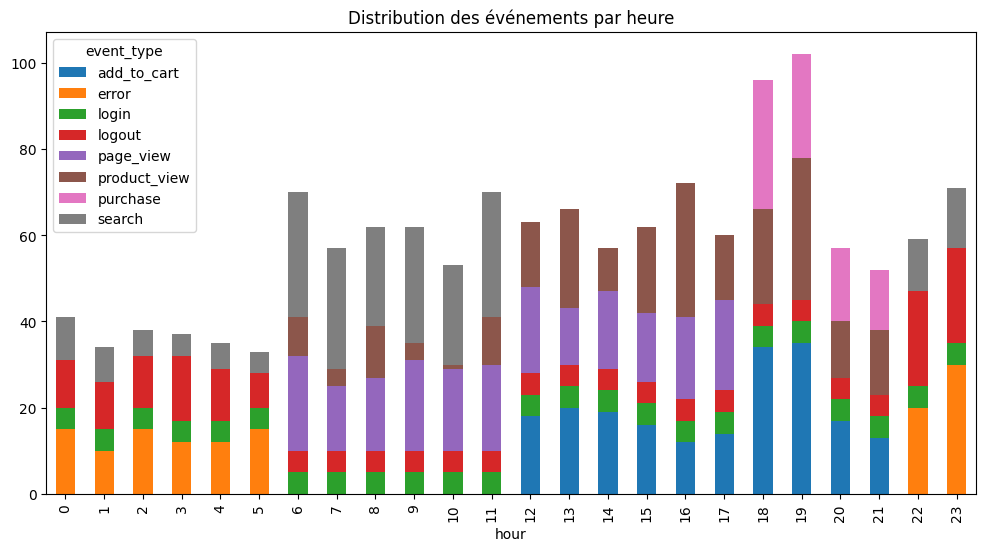

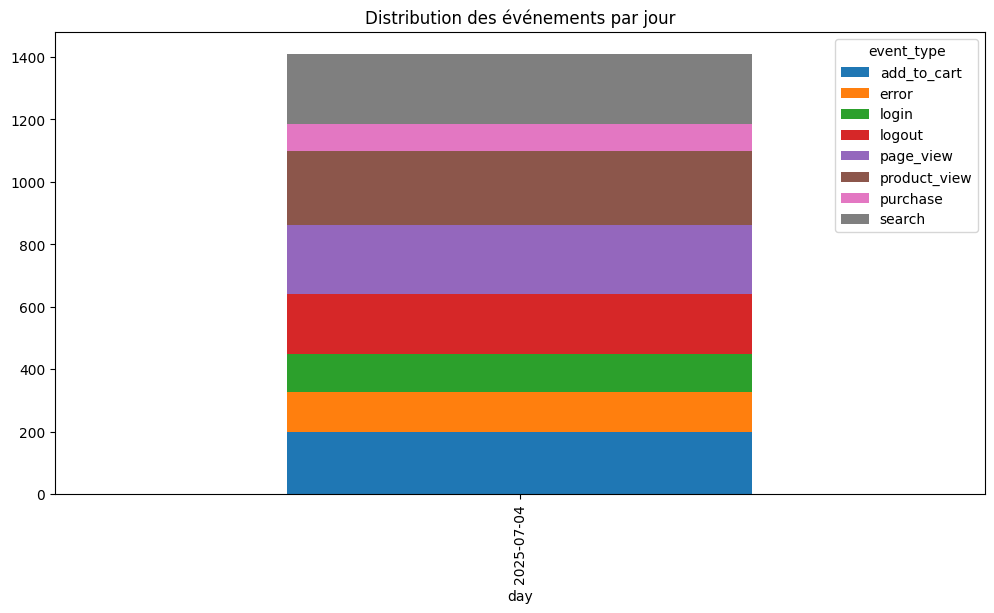

In [4]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date


df.groupby(['hour', 'event_type']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6), title="Distribution des événements par heure")
df.groupby(['day', 'event_type']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6), title="Distribution des événements par jour")


In [5]:
df.sort_values(['user_id', 'timestamp'], inplace=True)
df['next_event'] = df.groupby('user_id')['event_type'].shift(-1)

df['event_pair'] = df['event_type'] + " → " + df['next_event']
df['event_pair'].value_counts().head(10)


search → search                80
product_view → add_to_cart     70
product_view → product_view    64
page_view → page_view          60
add_to_cart → add_to_cart      58
error → logout                 51
add_to_cart → product_view     51
search → page_view             50
page_view → product_view       49
error → error                  49
Name: event_pair, dtype: int64

In [10]:
errors = df[df['event_type'] == 'error']
print(errors['data.error_code'].value_counts())

error_only_sessions = df[df['session_id'].isin(errors['session_id'])]['session_id'].value_counts()
print(error_only_sessions)


403.0    40
502.0    36
500.0    33
404.0    20
Name: data.error_code, dtype: int64
321faee4-d671-4660-9aa1-8e11ad8a771c    1
05685d70-ef7a-4e46-a120-4c19f4726d29    1
3f503b5a-9341-46d6-aa26-b48bd1ee3500    1
ad4efa81-1c64-4dae-854b-a3c2a8fccda8    1
e51c798b-315f-4760-8256-8a99824ac9c5    1
                                       ..
5a27412c-eccb-4a1a-9174-95e45a4d95f7    1
3b596ccf-0783-4b06-86bf-7df5da74f432    1
b6285be1-ba55-4651-8f95-01bbc4ca9285    1
87f8299b-824e-474b-894d-166077f7cbbf    1
74adfb15-aac9-461f-aa1d-cda205eef677    1
Name: session_id, Length: 129, dtype: int64


In [8]:
user_event_counts = df.groupby('user_id')['event_type'].value_counts().unstack().fillna(0)

X = StandardScaler().fit_transform(user_event_counts)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
user_event_counts['cluster'] = kmeans.labels_

user_event_counts.groupby('cluster').mean()


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


event_type,add_to_cart,error,login,logout,page_view,product_view,purchase,search
cluster,,,,,,,,
0,8.250000,0.250000,1.916667,2.000000,3.416667,8.000000,4.916667,1.333333
1,1.454545,1.727273,1.327273,2.181818,2.309091,2.000000,0.381818,2.618182
2,3.166667,5.166667,4.000000,8.166667,8.833333,5.333333,0.833333,10.833333


# Feature Engineering

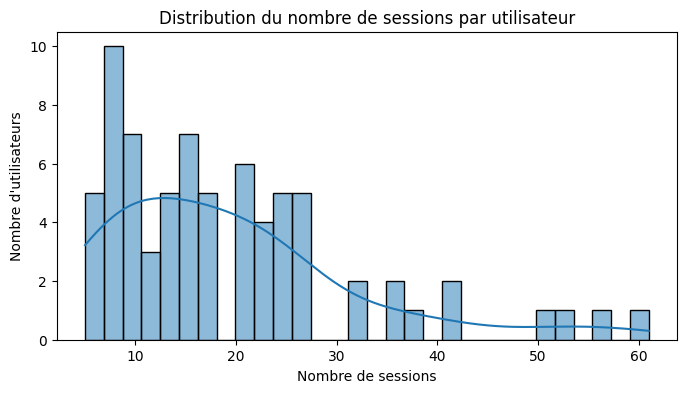

In [15]:
# Cette nouvelle feature servira à déterminer les utilisateurs les plus fidèles
# => On calcule le nombre total de sessions par utilisateur
sessions_per_user = df.groupby('user_id')['session_id'].nunique().rename('n_sessions')
df = df.merge(sessions_per_user, on='user_id', how='left')

plt.figure(figsize=(8,4))
sns.histplot(sessions_per_user, bins=30, kde=True)
plt.title("Distribution du nombre de sessions par utilisateur")
plt.xlabel("Nombre de sessions")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

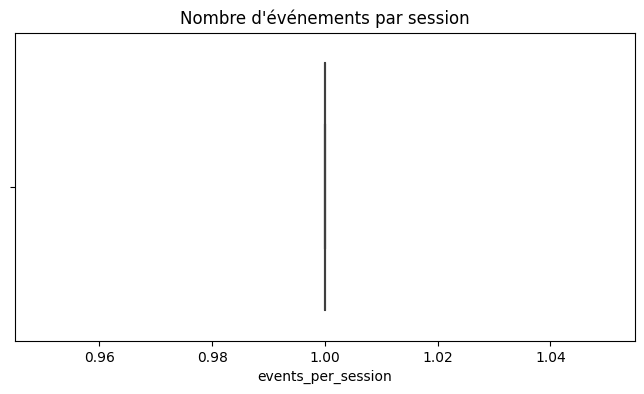

In [16]:
# Cette feature aidera à modéliser l’engagement : nombre d'événements par session
# Pas très utile au final si on prend les logs d'un seul jour. Sur plusieurs jours marche bien !

events_per_session = df.groupby('session_id')['event_type'].count().rename('events_per_session')
df = df.merge(events_per_session, on='session_id', how='left')

plt.figure(figsize=(8,4))
sns.boxplot(x=df['events_per_session'])
plt.title("Nombre d'événements par session")
plt.show()


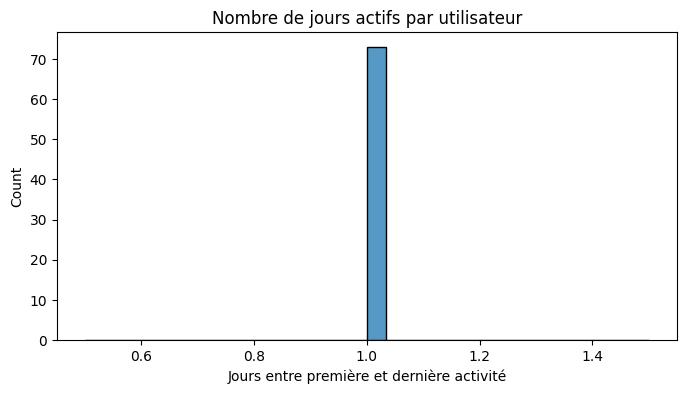

In [17]:
# Cette feature regarde la fréquence d'utilisation par utilisateur
# => Temps écoulé entre 1re et dernière activité
# Pas très utile si on prend les logs d'un seul jour. Sur plusieurs jours marche bien !

user_time_range = df.groupby('user_id')['timestamp'].agg(['min', 'max'])
user_time_range['active_days'] = (user_time_range['max'] - user_time_range['min']).dt.days + 1
df = df.merge(user_time_range['active_days'], on='user_id', how='left')

plt.figure(figsize=(8,4))
sns.histplot(user_time_range['active_days'], bins=30)
plt.title("Nombre de jours actifs par utilisateur")
plt.xlabel("Jours entre première et dernière activité")
plt.show()


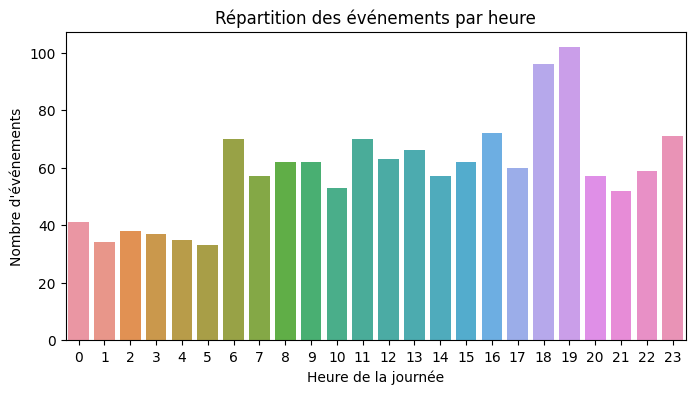

In [18]:
# Cette feature servira à détecter les utilisateurs actifs à certains moments
# => Heure de la journée

df['hour'] = df['timestamp'].dt.hour

plt.figure(figsize=(8,4))
sns.countplot(x='hour', data=df, order=sorted(df['hour'].unique()))
plt.title("Répartition des événements par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'événements")
plt.show()


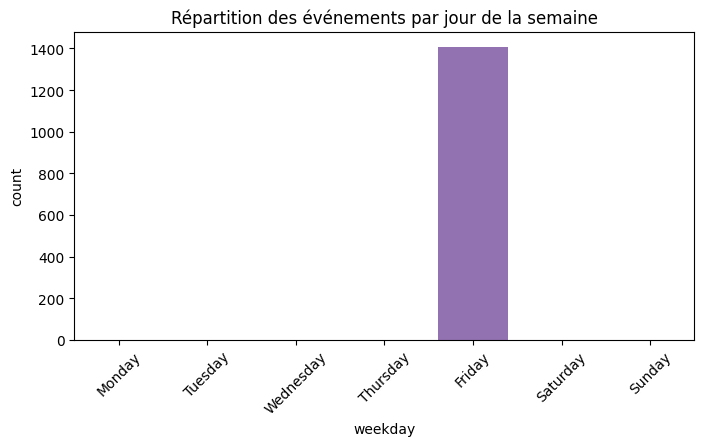

In [19]:
# Cette feature aide à capter les habitudes temporelles
# => Jour de la semaine
df['weekday'] = df['timestamp'].dt.day_name()

plt.figure(figsize=(8,4))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='weekday', data=df, order=order)
plt.title("Répartition des événements par jour de la semaine")
plt.xticks(rotation=45)
plt.show()

# Modelisation

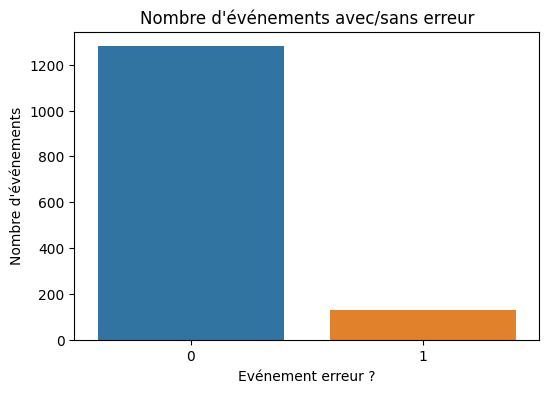

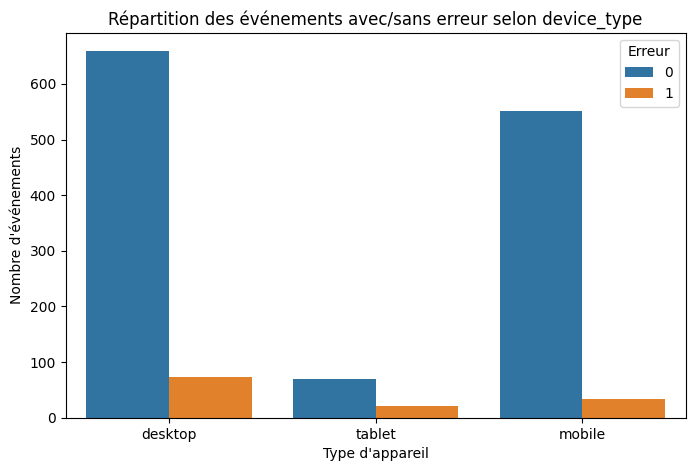

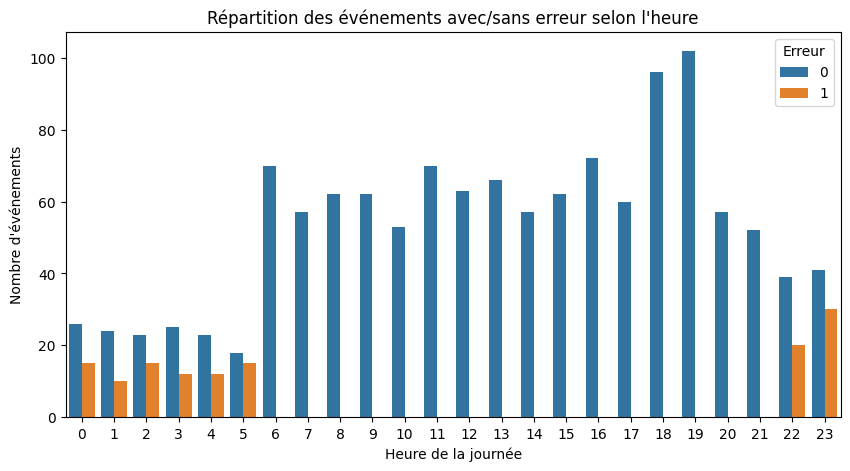

In [29]:
# Création de la target 'has_error' directement sur le df initial (événement = session)
df['has_error'] = (df['event_type'] == 'error').astype(int)

# Visualisation du nombre d'événements avec/sans erreur
plt.figure(figsize=(6,4))
sns.countplot(x='has_error', data=df)
plt.title("Nombre d'événements avec/sans erreur")
plt.xlabel("Evénement erreur ?")
plt.ylabel("Nombre d'événements")
plt.show()

# Répartition des erreurs par device_type
plt.figure(figsize=(8,5))
sns.countplot(x='device_type', hue='has_error', data=df)
plt.title("Répartition des événements avec/sans erreur selon device_type")
plt.xlabel("Type d'appareil")
plt.ylabel("Nombre d'événements")
plt.legend(title="Erreur")
plt.show()

# Répartition des erreurs par heure
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(10,5))
sns.countplot(x='hour', hue='has_error', data=df)
plt.title("Répartition des événements avec/sans erreur selon l'heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'événements")
plt.legend(title="Erreur")
plt.show()


In [31]:
df.columns

Index(['timestamp', 'event_type', 'session_id', 'user_id', 'ip_address',
       'user_agent', 'device_type', 'geo.country', 'geo.lat', 'geo.lon',
       'data.user_id', 'data.error_code', 'data.error_message', 'data.query',
       'data.page', 'data.product_id', 'data.price', 'data.quantity',
       'data.order_id', 'data.amount', 'data.items', 'has_error', 'hour',
       'device_type_code'],
      dtype='object')

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


df['has_error'] = (df['event_type'] == 'error').astype(int)
df['hour'] = df['timestamp'].dt.hour

df['device_type_code'] = df['device_type'].astype('category').cat.codes

df['country'] = df['geo.country']
df['country_code'] = df['country'].astype('category').cat.codes

features = ['hour', 'device_type_code', 'country_code']

X = df[features]
y = df['has_error']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       256
           1       0.08      0.04      0.05        26

    accuracy                           0.87       282
   macro avg       0.50      0.50      0.49       282
weighted avg       0.83      0.87      0.85       282

[[245  11]
 [ 25   1]]


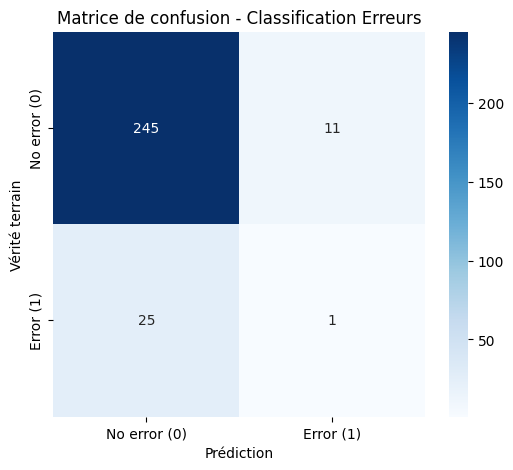

In [35]:
cm = confusion_matrix(y_test, y_pred)
labels = ['No error (0)', 'Error (1)']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion - Classification Erreurs')
plt.show()


Précision pour la classe 0 (pas d’erreur) : 0.91, parmi les sessions prédites comme "sans erreur", 91% le sont réellement.

Rappel pour la classe 0 : 0.96, très bon, la plupart des vraies sessions sans erreur sont bien identifiées.

F1-score pour la classe 0 : 0.93, bon compromis entre précision et rappel.

Précision pour la classe 1 (erreur) : 0.08, très faible, seules 8% des sessions prédites comme "avec erreur" en ont vraiment.

Rappel pour la classe 1 : 0.04, très faible, très peu de vraies erreurs sont détectées.

F1-score pour la classe 1 : 0.05, ce qui est faible, le modèle ne détecte quasiment pas les sessions avec erreurs.

Accuracy globale : 87%, semble bonne mais est trompeuse ici à cause du déséquilibre entre classes (beaucoup plus de sessions sans erreur).

Le modèle est donc très biaisé vers la classe majoritaire (pas d’erreur), et détecte mal les erreurs (faible recall et précision pour la classe 1).

Conclusion :
Il faudrait équilibrer les classes (par exemple via sur-échantillonnage, sous-échantillonnage, ou méthodes comme SMOTE), ou utiliser des métriques et stratégies adaptées au déséquilibre (ex: ajuster seuil, utiliser modèle qui gère l’imblance, etc.).

# Test avec un autre modèle : XGBoost

In [36]:
ratio = (y == 0).sum() / (y == 1).sum()

model_xgb = xgb.XGBClassifier(
    scale_pos_weight=ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.98      0.86      0.91       256
           1       0.37      0.85      0.52        26

    accuracy                           0.85       282
   macro avg       0.68      0.85      0.72       282
weighted avg       0.93      0.85      0.88       282

[[219  37]
 [  4  22]]


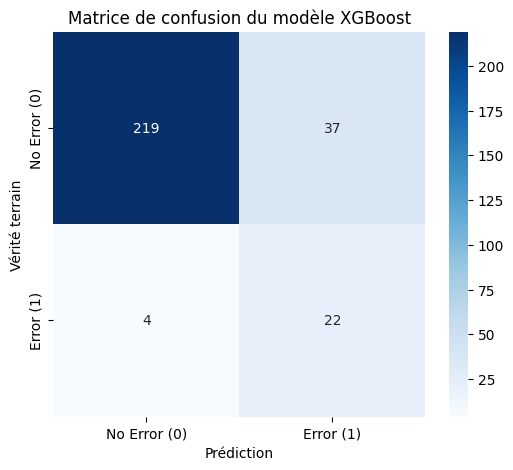

In [37]:
cm = confusion_matrix(y_test, y_pred_xgb)
labels = ['No Error (0)', 'Error (1)']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion du modèle XGBoost')
plt.show()


Précision (Precision) :

Pour la classe majoritaire (pas d'erreur), très haute (0.98), donc peu de faux positifs sur cette classe.

Pour la classe minoritaire (erreur), faible (0.37), ce qui signifie que beaucoup de sessions prédites comme "erreur" ne le sont pas vraiment (beaucoup de faux positifs).

Rappel (Recall) :

Excellent rappel sur la classe erreur (0.85), on détecte la plupart des vraies sessions avec erreur.

Rappel plus faible sur la classe majoritaire (0.86), on rate certains cas "pas d'erreur" (faux négatifs).

F1-score : Compromis entre précision et rappel, la classe erreur reste plus difficile à prédire (0.52) mais bien meilleure que le modèle précédent.

# Comparaison

Métrique | Random Forest | XGBoost
 
Accuracy | 0.87 | 0.85

Precision classe 1 (erreur) | 0.08 | 0.37

Recall classe 1 (erreur) | 0.04 | 0.85
F1-score classe 1 (erreur) | 0.05 | 0.52

Le Random Forest est plus conservateur, avec très peu de faux positifs mais détecte très peu les erreurs (très faible rappel et F1-score sur la classe erreur).

XGBoost, en revanche, détecte bien plus d’erreurs (très bon rappel), au prix d’un nombre plus élevé de faux positifs (précision plus faible).

Selon l’objectif métier, si on veut capter le plus possible d’erreurs même avec quelques faux positifs, XGBoost est meilleur.

Si on préfère éviter les faux positifs au prix de rater des erreurs, Random Forest est préféré.